In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np

# set some nicer plotting options
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

In [2]:
from pyspark.sql import SQLContext, HiveContext

In [3]:
sqc = SQLContext(sc)
hc = HiveContext(sc)

In [4]:
!hadoop fs -ls /user/roskarr/twitter

Picked up _JAVA_OPTIONS: -Xmx10G -Xms256m -XX:ParallelGCThreads=5
15/11/11 23:35:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 7 items
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:21 /user/roskarr/twitter/2014_05
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:26 /user/roskarr/twitter/2014_06
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:31 /user/roskarr/twitter/2014_07
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:37 /user/roskarr/twitter/2014_09
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:43 /user/roskarr/twitter/2014_10
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:49 /user/roskarr/twitter/2014_11
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:50 /user/roskarr/twitter/2014_12


In [5]:
!hadoop fs -du -h /user/roskarr/twitter

Picked up _JAVA_OPTIONS: -Xmx10G -Xms256m -XX:ParallelGCThreads=5
15/11/11 23:35:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
55.1 G  /user/roskarr/twitter/2014_05
31.7 G  /user/roskarr/twitter/2014_06
51.0 G  /user/roskarr/twitter/2014_07
59.6 G  /user/roskarr/twitter/2014_09
61.9 G  /user/roskarr/twitter/2014_10
62.0 G  /user/roskarr/twitter/2014_11
12.1 G  /user/roskarr/twitter/2014_12


In [101]:
%%time
data = hc.read.parquet('/user/roskarr/twitter/2014_09','/user/roskarr/twitter/2014_1*')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.22 s


In [102]:
import pyspark.sql.functions as func
from pyspark.sql import Row
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, ArrayType, StringType, StructField, StructType, DateType, DataType, DateConverter, DatetimeConverter, TimestampType, BooleanType
import datetime

In [103]:
convert_date_string = func.udf(lambda date_string: datetime.date.strftime(datetime.datetime.strptime(date_string, '%a %b %d %H:%M:%S +0000 %Y'),'%Y-%m-%d %H:%M:%S'), StringType())

In [104]:
# make UDF for converting the date string to a datetime object
datetime_udf = func.udf(lambda date_string: datetime.strptime(date_string, '%a %b %d %H:%M:%S +0000 %Y'), DateType())

In [105]:
hash_text_udf = func.udf(lambda row: [r.text for r in row], returnType=ArrayType(StringType()))

In [106]:
# only keep the tweets with at least one hashtag
hashtag_df = (data.select('created_at', 'entities.hashtags')
                .filter(func.size('hashtags') > 0)
                .withColumn('hash_text', hash_text_udf('hashtags'))
                .select(convert_date_string('created_at').alias('date'), func.explode('hash_text').alias('hashtag'))
                .withColumn('hashtag', func.lower(func.col('hashtag'))))
             #   .repartition(1200))
hashtag_df.cache()

DataFrame[date: string, hashtag: string]

In [107]:
hashtag_df.show(truncate=False)

+-------------------+--------------+
|date               |hashtag       |
+-------------------+--------------+
|2014-09-01 06:29:00|lovemusic     |
|2014-09-01 06:29:00|uangtunai     |
|2014-09-01 06:29:00|500ribu       |
|2014-09-01 06:29:00|samsung       |
|2014-09-01 06:29:00|smartphone    |
|2014-09-01 06:29:00|my_inspiration|
|2014-09-01 06:29:00|三代目jsbが好きな人rt |
|2014-09-01 06:29:00|rtしてくれた人フォロー  |
|2014-09-01 06:29:02|عرب           |
|2014-09-01 06:29:02|الرياض        |
|2014-09-01 06:29:02|الهلال        |
|2014-09-01 06:29:02|غرد_بصورة     |
|2014-09-01 06:29:02|النصر         |
|2014-09-01 06:29:02|دبي           |
|2014-09-01 06:29:02|رتويت         |
|2014-09-01 06:29:02|نكت           |
|2014-09-01 06:29:02|الامارات      |
|2014-09-01 06:29:02|صباح_الخير    |
|2014-09-01 06:29:02|شعر           |
|2014-09-01 06:29:02|porn          |
+-------------------+--------------+
only showing top 20 rows



### Simple word count revisited

Now that we have a `DataFrame` consisting of `(timestamp, hashtag)` columns, lets do a simple word count using the `DataFrame` API. This will let us decide later on which hashtags we might be interested in investigating further. 

In [108]:
%%time 
hashtag_df.groupBy('hashtag').count().sort('count', ascending=False).show(50, False)

+--------------------------+-------+
|hashtag                   |count  |
+--------------------------+-------+
|mtvstars                  |2415671|
|emabiggestfans1d          |1651343|
|emabiggestfansjustinbieber|1546400|
|vote5sos                  |1165841|
|gameinsight               |1143538|
|votefifthharmony          |1074212|
|kcaargentina              |887787 |
|android                   |821058 |
|teamfollowback            |607494 |
|تطبيق_قرآنى               |592314 |
|رتويت                     |592117 |
|rt                        |589686 |
|androidgames              |584018 |
|الهلال                    |499439 |
|rtした人全員フォローする             |484903 |
|ipad                      |471822 |
|الرياض                    |466448 |
|sougofollow               |452099 |
|السعودية                  |436591 |
|相互フォロー                    |427585 |
|ipadgames                 |411636 |
|follow                    |410051 |
|porn                      |388949 |
|followback                |356910 |
|

As we can see here, there are lots os languages represented on Twitter! This is very interesting by itself, but for now lets focus on just plain ascii hash tags which we are more likely to understand: 

In [109]:
# define a helper UDF that can be used to filter non-ascii hashtags
def is_ascii(s):
    return all(ord(c) > 0 and ord(c) < 128 for c in s)
is_ascii_udf = func.udf(is_ascii, BooleanType())

In [110]:
hashtag_df = hashtag_df.filter(is_ascii_udf('hashtag'))

### Daily hashtag trends

Now lets do something slightly more complicated and incorporate the time data into our analysis. First, we'll try daily trends and later on do more fine-grained analysis. 

To get information about daily hashtag usage, we must first convert the date string into a number representing day of the year. The [Spark DataFrame functions module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) provides a function [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) that will do this for us and we can use it just like we used the User Defined Functions (UDFs) above. 

In [111]:
daily_hashtag = hashtag_df.select(func.month('date').alias('month'),
                                  func.weekofyear('date').alias('week'),
                                  func.dayofyear('date').alias('day'), 
                                  'hashtag')
daily_hashtag.show(5)

+-----+----+---+----------+
|month|week|day|   hashtag|
+-----+----+---+----------+
|    9|  36|244| lovemusic|
|    9|  36|244| uangtunai|
|    9|  36|244|   500ribu|
|    9|  36|244|   samsung|
|    9|  36|244|smartphone|
+-----+----+---+----------+
only showing top 5 rows



We can now use the same technique as above using `groupBy` to get daily counts for each hashtag. Since we want to satisfy two conditions (counts per day and counts per hashtag), we simply give `groupBy` two columns:

In [112]:
day_counts = (daily_hashtag.select('day', 'hashtag', 'week').groupby('day', 'hashtag', 'week')
                       .count())

#### Important aside concerning `count()`

The use of `count()` here is very confusing -- in this case, `count()` is a method of a [GroupedData](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData) object, which performs a counting of items in each group. Our grouping here is defined by week, day, and hashtag, so calling `count()` gives us the number of times a hashtag appears each week. To make it even more confusing, `count()` in this case actually returns a `DataFrame`, with "count" as one of the columns. 

However, we are much more used to seeing `count()` as an RDD method! There, it returns the number of elements in the RDD, which is much different. See for example the line below, which uses `count()` as an RDD method and actually just returns the number of rows: 

In [113]:
%time day_counts.sort('day').count()

CPU times: user 134 ms, sys: 95 ms, total: 229 ms
Wall time: 26.1 s


16143463

In [114]:
day_counts.show(5)

+---+--------------------+----+-----+
|day|             hashtag|week|count|
+---+--------------------+----+-----+
|249|explainafilmplotb...|  36| 3171|
|249|                 bbc|  36|   88|
|249|      exoplanetinbkk|  36|  217|
|249|            discount|  36|   45|
|249|             pokemon|  36|   31|
+---+--------------------+----+-----+
only showing top 5 rows



The same counting of daily occurences of each hashtag can be done with an RDD operation using a `map` and `reduceByKey`, though it might look a bit messier: 

In [115]:
day_counts_rdd = daily_hashtag.rdd.map(lambda r: ((r.day, r.hashtag, r.week), 1)).reduceByKey(lambda a,b: a+b)

In [116]:
%time day_counts_rdd.sortBy(lambda ((day, hashtag, week), count): day).count()

CPU times: user 871 ms, sys: 335 ms, total: 1.21 s
Wall time: 1min 20s


16143463

The `DataFrame` API avoids shipping data back and forth to the Python intepreter (and can do some extra optimizations) so the performance difference can be significant, as we can see above. 

Lets make sure that the results are the same by looking up a hashtag in both places:

In [117]:
day_counts_rdd.lookup((274,'retweet',40))

[3238]

In [118]:
day_counts.filter((day_counts.hashtag == 'retweet') & (day_counts.day == 274)).show()

+---+-------+----+-----+
|day|hashtag|week|count|
+---+-------+----+-----+
|274|retweet|  40| 3238|
+---+-------+----+-----+



At this point we should persist `day_counts` in memory since we'll be using it later on. 

In [119]:
day_counts.cache()

DataFrame[day: int, hashtag: string, week: int, count: bigint]

We can get a quick idea of the most popular hashtags by looking at the weekly averages of daily hashtag counts:

In [120]:
day_counts.groupBy('week', 'hashtag').avg('count').sort('avg(count)', ascending=False).show(100)

+----+--------------------+------------------+
|week|             hashtag|        avg(count)|
+----+--------------------+------------------+
|  45|            vote5sos|          159567.0|
|  45|    votefifthharmony|149373.85714285713|
|  47|            mtvstars|130512.57142857143|
|  48|            mtvstars| 97469.71428571429|
|  49|            mtvstars| 71965.85714285714|
|  45|    emabiggestfans1d| 65711.57142857143|
|  46|            mtvstars|           63171.2|
|  45|emabiggestfansjus...| 58197.28571428572|
|  42|    emabiggestfans1d|54077.857142857145|
|  42|emabiggestfansjus...| 52082.28571428572|
|  44|    emabiggestfans1d| 49943.57142857143|
|  44|emabiggestfansjus...| 47231.71428571428|
|  46|           murrayftw|37438.666666666664|
|  43|        kcaargentina| 36302.28571428572|
|  43|    emabiggestfans1d|30190.571428571428|
|  43|emabiggestfansjus...| 29586.85714285714|
|  37|              mtvema|28533.666666666668|
|  42|        kcaargentina| 25964.14285714286|
|  40|       

Apparently, the [MTV Europe Music Awards](https://en.wikipedia.org/wiki/2014_MTV_Europe_Music_Awards) happened in late 2014... (and [yet another boy band](https://en.wikipedia.org/wiki/One_Direction) is on the scene?)

## Using `window` functions

### top daily hashtags

Now lets say we want to know the top tweets for each day. This is a non-trivial thing to try and compute using a standard RDD, but the `DataFrame` API gives us "window" functions that let us do it relatively easily. 

In [121]:
daily_window = Window.partitionBy('day').orderBy(func.desc('count'))

In [122]:
daily_rank = func.rank().over(daily_window)

In [123]:
(day_counts.select('day', 'count', 'hashtag', daily_rank.alias('rank'))
           .filter('rank < 6')
           .show(20))

+---+-----+----------------+----+
|day|count|         hashtag|rank|
+---+-----+----------------+----+
|244|17639|      followmejg|   1|
|244|12164|     gameinsight|   2|
|244| 8264|         android|   3|
|244| 6348|    androidgames|   4|
|244| 5551|            mufc|   5|
|245|16592|     gameinsight|   1|
|245|13997|jackandjacktides|   2|
|245|11964|         android|   3|
|245| 7939|    androidgames|   4|
|245| 7686|  teamfollowback|   5|
|246|16222|     gameinsight|   1|
|246|11924|         android|   2|
|246| 8655|jackandjacktides|   3|
|246| 8536|    mashnewvideo|   4|
|246| 8012|    androidgames|   5|
|247|15375|     gameinsight|   1|
|247|13369|1dwwafilmtrailer|   2|
|247|10783|         android|   3|
|247| 8784|      favnashpic|   4|
|247| 7874|    androidgames|   5|
+---+-----+----------------+----+
only showing top 20 rows



### More complicated example: calculating the daily standard deviation based on a weekly window

In [124]:
weekly_window = Window.partitionBy('week', 'hashtag')

In [125]:
mean_diff = day_counts['count'] - func.mean('count').over(weekly_window)

In [126]:
variance_arg = (1./7.)*mean_diff*mean_diff

In [127]:
weekly_stats = (day_counts.withColumn('var_arg', variance_arg)
                         .groupBy('week', 'hashtag')
                         .sum('var_arg')
                         .withColumn('stddev', func.sqrt('sum(var_arg)'))
                         .sort('stddev', ascending=False))

In [128]:
weekly_stats_window = Window.partitionBy('week').orderBy(func.desc('stddev'))

In [143]:
(weekly_stats.select('week', 'hashtag', 'stddev', 
                     func.rank().over(weekly_stats_window).alias('rank'), 
                     func.percentRank().over(weekly_stats_window).alias('percent_rank'))
             ).show(200)

+----+--------------------+------------------+----+--------------------+
|week|             hashtag|            stddev|rank|        percent_rank|
+----+--------------------+------------------+----+--------------------+
|  36|          followmejg| 6157.914018658151|   1|                 0.0|
|  36|    jackandjacktides| 5240.560026154422|   2|1.431055331754402...|
|  36|    1dwwafilmtrailer|4320.0187623578895|   3|2.862110663508804...|
|  36|             riprise|3465.8437851185863|   4|4.293165995263207E-6|
|  36|        mashnewvideo| 2887.346652286118|   5|5.724221327017609E-6|
|  36|          favnashpic| 2746.839352522073|   6|7.155276658772012E-6|
|  36|             ripeunb|2543.1875948994943|   7|8.586331990526415E-6|
|  36|         gameinsight| 2245.851758786393|   8|1.001738732228081...|
|  36|   connorhit2million|2196.1062539336767|   9|1.144844265403521...|
|  36|             android|  2187.59442011859|  10|1.287949798578962E-5|
|  36|                mufc|1962.2773005051508|  11|

In [151]:
def plot_hashtag_timeseries(hashtag): 
    day_data = day_counts.filter(day_counts['hashtag'] == hashtag).select('day', 'count').sort('day').toPandas()
    day_data.plot.line(x='day',y='count', label = hashtag)

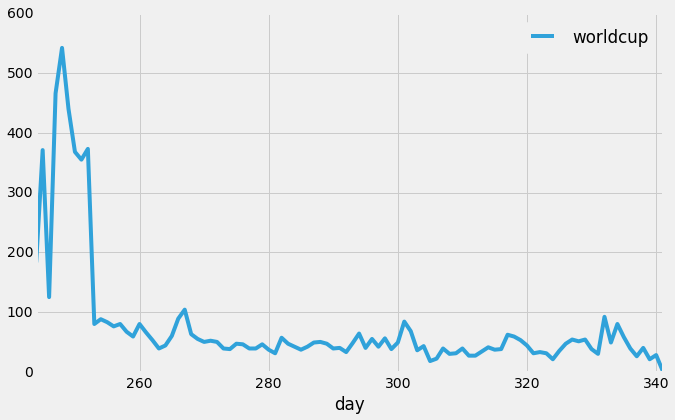

In [152]:
plot_hashtag_timeseries('worldcup')

In [147]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [150]:
interact(f, x='Hi there!');

u'Hi there!'

None

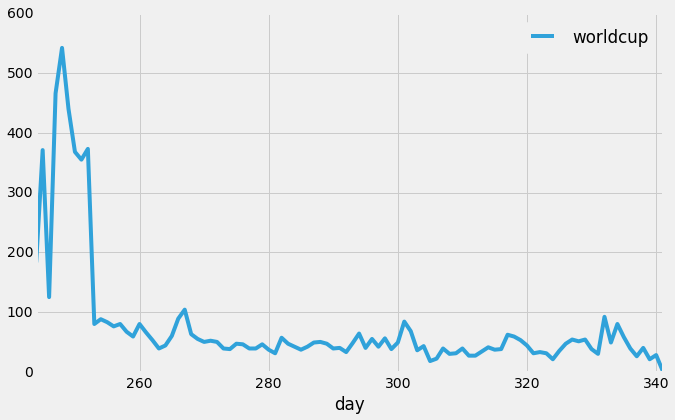

In [154]:
interact(plot_hashtag_timeseries, hashtag='worldcup')